In [2]:
cd '/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks'

/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks


In [3]:
%%time
import pickle

import numpy as np
import pandas as pd 

from importlib import reload

import helper_funcs;reload(helper_funcs);from helper_funcs import *
#import make_models;reload(make_models);from make_models import *
import make_models2;reload(make_models2);from make_models2 import *

from functools import partial
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

from datetime import datetime

import shutil
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

import ants

CPU times: user 11.4 s, sys: 3.54 s, total: 15 s
Wall time: 25.6 s


In [4]:
dataFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE-Anat-64iso-S982.npz'
dfFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE_legend_S982.csv'

ABIDE_data = np.load(dataFnOut)['data']
df = pd.read_csv(dfFnOut)

patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2
abide_asd = ABIDE_data[patients,:,:,:]

arr = np.load('../Data/SFARI-Anat-64iso-S121.npz')
dfs = pd.read_csv('../Data/sfari_legend_S121.csv')

SFARI_data = arr['data']
SFARI_subs = arr['subs']

sfari_subs_td = dfs['family_type'].values=='non-familial-control'
sfari_subs_dupl = dfs['family_type'].values=='16p-duplication'
sfari_subs_del = dfs['family_type'].values=='16p-deletion'

In [5]:
patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2

In [6]:
# LOAD VAE
latent_dim=32;batch_size=64;disentangle=False;gamma=100
encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64,64,64,1), 
                                            latent_dim=32, 
                                            batch_size = batch_size, 
                                            disentangle=True,
                                            gamma=100,
                                            kernel_size = 3,
                                            filters = 48,
                                            intermediate_dim = 128,
                                            nlayers = 2,
                                            bias=True)


#fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan12th_16d'
#fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Feb_26_32DB64G1'
#fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Feb_26_32DB64G100_DisTrue'
#fn = '/mmfs1/data/aglinska/tf_outputs/VAE/APR_4th_D32DTrue_G100'
#fn = '/mmfs1/data/aglinska/tf_outputs/VAE/20210919-1144'
fn = '/mmfs1/data/aglinska/tf_outputs/VAE/20210920-2122'

loss = list()
print('ready')
if os.path.exists(fn+'_loss.pickle'):
    print('loading')
    vae.load_weights(fn)
    loss = pickle.load(open(fn+'_loss.pickle','rb'))

ready
loading


In [7]:
%%time 
# LOAD CVAE
latent_dim = 16;batch_size = 32;beta = 1;gamma = 100;disentangle = True
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
loss = list()    

fdir = '/mmfs1/data/aglinska/tf_outputs/CVAE/'

#fn = f'{now().strftime("%b%d_%H%M")}_D{latent_dim}B{beta}G{gamma}_D{disentangle}'
#fn = 'Feb04_0524_D16B1G100_DTrue'
#fn = os.path.join(fdir,'Mar18_1312_CVAE_D16B1G1_adam_rData2')
#fn = os.path.join(fdir,'Mar20_2125_CVAE_D16B1G1_ADAM_Bspline_r2_new')

fn = os.path.join(fdir,fn)
fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb23_1551_D16B1G100_DTrue'

loss = pickle.load(open(fn+'_loss.pickle','rb'))
cvae.load_weights(fn)

CPU times: user 3.15 s, sys: 1.24 s, total: 4.39 s
Wall time: 6.4 s


In [ ]:
def get_case_control(s):
    sub_sex = df['Sex'].values[s]
    sub_age = df['AgeAtScan'].values[s]
    sub_iq = df['FIQ'].values[s]
    
    
    tempdf = df.copy()
    tempdf = tempdf.iloc[~patients]
    tempdf = tempdf.iloc[tempdf['Sex'].values==sub_sex]
    tempdf = tempdf.iloc[~tempdf['FIQ'].isna().values]
    
    e1 = abs((tempdf['FIQ'].values-sub_iq))*.5
    e2 = abs((tempdf['AgeAtScan'].values-sub_age))
    
    simsub = tempdf.iloc[np.argsort(e1+e2)].iloc[0][['BIDS_ID','Sex','AgeAtScan','FIQ']]
    
    targ = df.iloc[s][['BIDS_ID','Sex','AgeAtScan','FIQ']]
    cont = simsub
    
    match = {}
    match['targ'] = targ
    match['cont'] = cont
    
    return match

In [ ]:
asd_idx = np.nonzero(patients)[0]

In [125]:
i = 0

In [136]:
i+=1
s = asd_idx[i]
print(get_case_control(s)['targ'])
print('____________________')
print(get_case_control(s)['cont'])
cont_idx = np.nonzero(get_case_control(s)['cont']['BIDS_ID'])[0][0]

BIDS_ID      sub-028
Sex                2
AgeAtScan         29
FIQ              118
Name: 27, dtype: object
____________________
BIDS_ID      sub-462
Sex                2
AgeAtScan      29.13
FIQ              120
Name: 458, dtype: object


In [137]:
sub = df['BIDS_ID'].values[s]
fn = f'~/data/fMRI_InData/abide_bids/{sub}/anat/{sub}_brain.nii'

im = ants.image_read(fn)
im64 = ants.resample_image(image=im,resample_params=(64,64,64),use_voxels=True)

mat = ABIDE_data[s,:,:,:]
mat_asd = mat

S = s_encoder.predict(mat[np.newaxis,:,:,:])[2]
Z = z_encoder.predict(mat[np.newaxis,:,:,:])[2]
z_ = np.zeros(Z.shape)

pred = cvae_decoder.predict(np.hstack((Z,S)))[0,:,:,:,0]
pred_Z = cvae_decoder.predict(np.hstack((Z,z_)))[0,:,:,:,0]

imOut_ZS = im64.new_image_like(pred)
imOut_Z0 = im64.new_image_like(pred_Z)

imOut_ZS = ants.iMath_normalize(imOut_ZS)
imOut_Z0 = ants.iMath_normalize(imOut_Z0)
imOut_Z0 = ants.registration(fixed=imOut_ZS,moving=imOut_Z0,type_of_transform='Rigid')['warpedmovout']

tx = ants.registration(fixed=imOut_ZS,moving=imOut_Z0,type_of_transform='SyN')

J = ants.create_jacobian_determinant_image(domain_image=imOut_ZS,tx=tx['fwdtransforms'][0])
J = J-1
Jmat = J.numpy()

<ipython-input-138-d71b99bd2cbc>:5: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-138-d71b99bd2cbc>:8: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



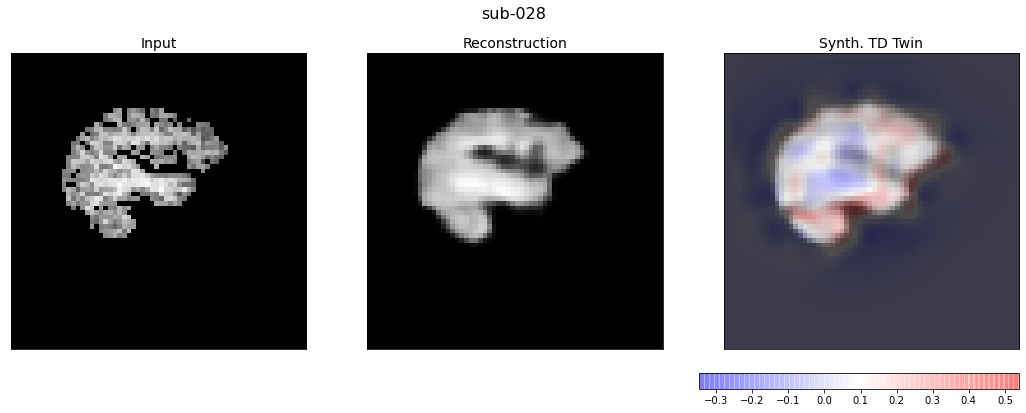

In [138]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1);plt.imshow(np.rot90(im64.numpy()[16,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);plt.title('Input',fontsize=14);
plt.subplot(1,3,2);plt.imshow(np.rot90(imOut_ZS.numpy()[16,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);plt.title('Reconstruction',fontsize=14);
plt.subplot(1,3,3);plt.imshow(np.rot90(imOut_Z0.numpy()[16,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);plt.title('Synth. TD Twin',fontsize=14);
plt.subplot(1,3,3);plt.imshow(np.rot90(Jmat[16,:,:]),cmap='bwr',alpha=.3);plt.xticks([]);plt.yticks([]);plt.title('Synth. TD Twin',fontsize=14);
cbar = plt.colorbar(use_gridspec=False,anchor=(0,-3),orientation='horizontal',shrink=1.3)
plt.suptitle(sub,fontsize=16)
plt.tight_layout()

In [141]:
s = cont_idx

sub = df['BIDS_ID'].values[s]
fn = f'~/data/fMRI_InData/abide_bids/{sub}/anat/{sub}_brain.nii'

im = ants.image_read(fn)
im64 = ants.resample_image(image=im,resample_params=(64,64,64),use_voxels=True)

mat = ABIDE_data[s,:,:,:]

S = s_encoder.predict(mat[np.newaxis,:,:,:])[2]
Z = z_encoder.predict(mat[np.newaxis,:,:,:])[2]
z_ = np.zeros(Z.shape)

pred = cvae_decoder.predict(np.hstack((Z,S)))[0,:,:,:,0]
pred_Z = cvae_decoder.predict(np.hstack((Z,z_)))[0,:,:,:,0]

imOut_ZS = im64.new_image_like(pred)
imOut_Z0 = im64.new_image_like(pred_Z)

im = im64.new_image_like(mat)
im_asd = im64.new_image_like(mat_asd)

imOut_ZS = ants.iMath_normalize(imOut_ZS)
imOut_Z0 = ants.iMath_normalize(imOut_Z0)
imOut_Z0 = ants.registration(fixed=imOut_ZS,moving=imOut_Z0,type_of_transform='Rigid')['warpedmovout']

tx = ants.registration(fixed=im,moving=im_asd,type_of_transform='SyN')
J = ants.create_jacobian_determinant_image(domain_image=im,tx=tx['fwdtransforms'][0])
#J = ants.create_jacobian_determinant_image(domain_image=im,tx=tx['invtransforms'][1])
J = J-1
Jmat = J.numpy()

<ipython-input-142-67b70048ab8f>:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-142-67b70048ab8f>:11: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



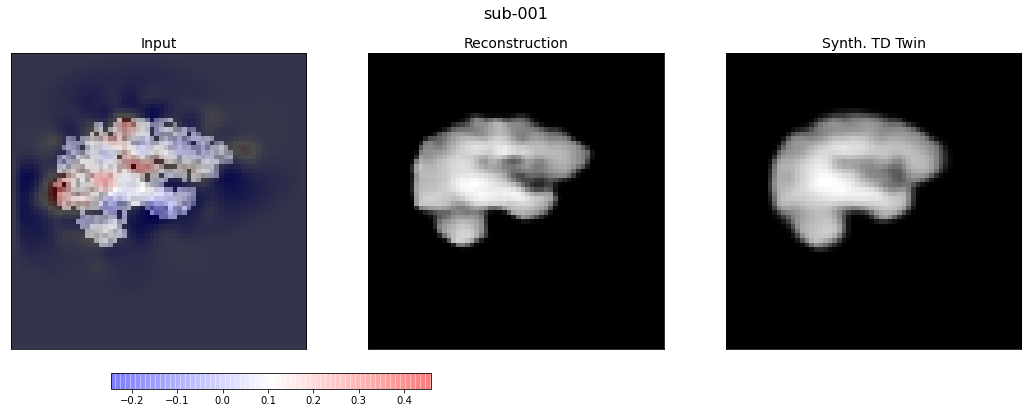

In [142]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,2);plt.imshow(np.rot90(imOut_ZS.numpy()[16,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);plt.title('Reconstruction',fontsize=14);
plt.subplot(1,3,3);plt.imshow(np.rot90(imOut_Z0.numpy()[16,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);plt.title('Synth. TD Twin',fontsize=14);
#plt.subplot(1,3,3);plt.imshow(np.rot90(Jmat[16,:,:]),cmap='bwr',alpha=.3);plt.xticks([]);plt.yticks([]);plt.title('Synth. TD Twin',fontsize=14);

plt.subplot(1,3,1);plt.imshow(np.rot90(im64.numpy()[16,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);plt.title('Input',fontsize=14);
ax = plt.subplot(1,3,1);plt.imshow(np.rot90(Jmat[16,:,:]),cmap='bwr',alpha=.3);plt.xticks([]);plt.yticks([])
cbar = plt.colorbar(use_gridspec=False,anchor=(0,-3),orientation='horizontal',shrink=1.3,ax=ax)

plt.suptitle(sub,fontsize=16)
plt.tight_layout()